# **Data Analysis Notebook**

## Objectives
- Fulfil Business Requirement 1 - the local government wants a study of the patterns and relationships within the student data, with the goal of identifying correlations with the exam scores data

## Inputs
- student=exam-results.csv file

## Outputs
- Various plots and reports that indicate patterns and relationships

In [18]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pingouin as pg
sns.set_theme(style="whitegrid")

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

## Load Data

First, we load the dataset output from the Data Collection notebook

In [4]:
import pandas as pd
df = pd.read_csv('outputs/datasets/collection/student-exam-results.csv')
df.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score,literacy_score
0,male,group A,high school,standard,completed,67,67,63,65,65
1,female,group D,some high school,free/reduced,none,40,59,55,51,57
2,male,group E,some college,free/reduced,none,59,60,50,56,55
3,male,group B,high school,standard,none,77,78,68,74,73
4,male,group E,associate's degree,standard,completed,78,73,68,73,70


We now want to become more familiar with the dataset. We can do this with a Pandas Profile Report

In [6]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


### Profile report discussion

In the `gender` column, we see 517 records for male students and 483 records for female students. This indicates that the `gender` column's values are equally distributed, therefore a Machine Learning model that takes a student's gender as an input should not be biased one way or the other.

In the `ethnicity` column, we see that the ethnicities are imbalanced. This could be problematic, as a machine learning model that takes a student's ethnicity as an input would be more reliable when predicting test scores for Group C (323 records) than Group A (79 records).

In the `parental_education` column, we see that the `some college`, `associates degree`, `high school` and `some high school` categories are approximately equally distributed, however the `bachelor's degree` category contains about half as many records. This could be problematic.

In the `lunch_program` column, we see that there are about twice as many `standard` entries as there are `free/reduced` entries. This could prove problematic.

In the `test_preparation_course` column, we see that there are about twice as many `none` entries as there are `completed` entries. This could prove problematic.

We then come to the numerical exam score variables. These appear to be normally distributed. We should check this using a histogram

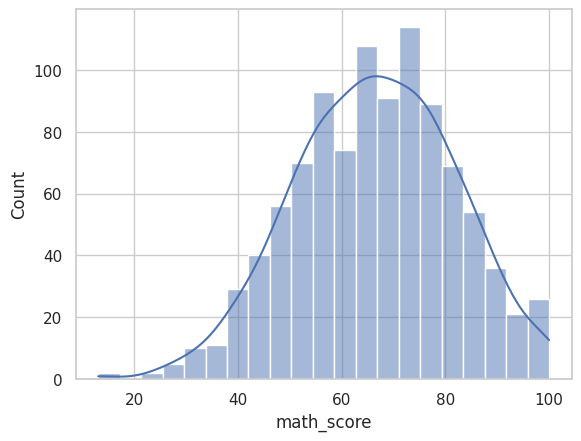

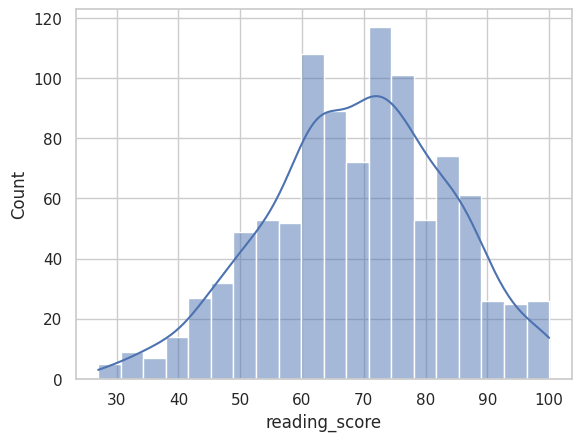

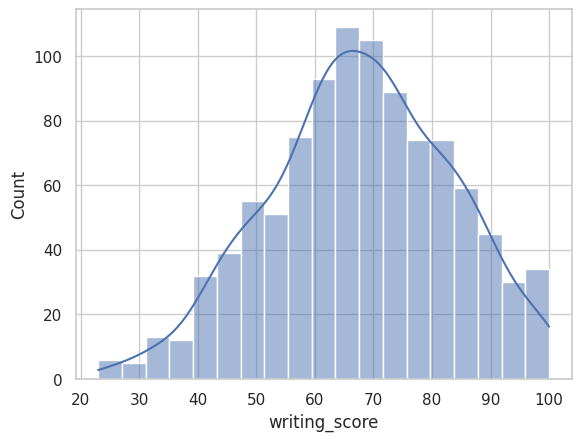

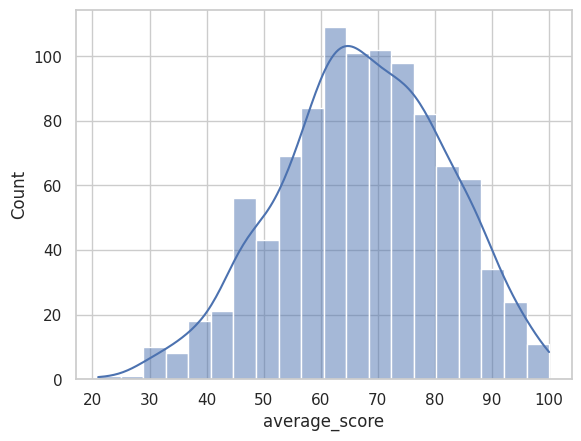

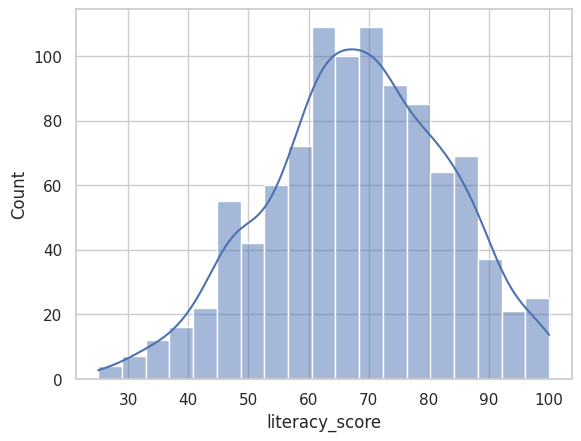

In [16]:
for column in df.columns[5:10]:
    sns.histplot(data=df, kde=True, x=column)
    plt.show()

The histograms appear to show that the numerical variables are normally distributed. We can use the Pingouin library and the Shapiro-Wilk test to mathematically confirm this

In [19]:
pg.normality(data=df, alpha=0.05)

,W,pval,normal
math_score,0.995075,0.002504,False
reading_score,0.993004,0.000118,False
writing_score,0.993029,0.000123,False
average_score,0.993946,0.000454,False
literacy_score,0.993120,0.000139,False


This is an interesting result from the Shapiro-Wilk test. It appears that the plots were misleading us, and that the scores are not normally distributed. We could do some Numerical Data Transformation and use the Box-Cox or Yeo-Johnson transformers.

### Transformers

As a precaution, I will explore the results of the Box-Cox and Yeo-Johnson transformers. If the planned ML pipeline performs poorly on the standard data, we may ascribe this to the abnormally distributed data, and can then test it with the (hopefully) normally distributed data output from the Box-Cox and Yeo-Johnson transformers. Since the transformers are used in pipelines, we can apply a transformer as one of the first steps. 

First, we must import the transformer and the SkLearn Pipeline package

In [22]:
from feature_engine import transformation as vt
from sklearn.pipeline import Pipeline

Now we can define a transformer pipeline using the Box-Cox transformer

In [27]:
pipeline_box_cox = Pipeline([
    ('Box-Cox-Transformer', vt.BoxCoxTransformer())
])

df_box_cox = pipeline_box_cox.fit_transform(df)
df_box_cox.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score,literacy_score
0,male,group A,high school,standard,completed,121.091609,162.702436,113.383625,143.938963,138.005450
1,female,group D,some high school,free/reduced,none,65.421602,138.343992,96.411057,106.234436,117.271836
2,male,group E,some college,free/reduced,none,104.072425,141.342768,86.028589,119.442519,112.189527
3,male,group B,high school,standard,none,142.889175,197.481846,124.198855,169.279935,159.340170
4,male,group E,associate's degree,standard,completed,145.098631,181.497357,124.198855,166.425182,151.272705


The transformer appears to have only targetted the numerical variables. We will display the un-transformed df just to be sure that the categorical variables remain unchanged

In [24]:
df.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score,literacy_score
0,male,group A,high school,standard,completed,67,67,63,65,65
1,female,group D,some high school,free/reduced,none,40,59,55,51,57
2,male,group E,some college,free/reduced,none,59,60,50,56,55
3,male,group B,high school,standard,none,77,78,68,74,73
4,male,group E,associate's degree,standard,completed,78,73,68,73,70


Excellent. The transformer has not targetted the categorical variables.

Now we can run the Shapiro-Wilk test on the results of the Box-Cox transformer to see if it has more normally distributed the data

In [25]:
pg.normality(data=df_box_cox, alpha=0.05)

,W,pval,normal
math_score,0.995915,0.009541,False
reading_score,0.994572,0.001154,False
writing_score,0.993813,0.000373,False
average_score,0.995235,0.003216,False
literacy_score,0.994359,0.000837,False


It appears that the Box-Cox transformer has failed to more normally distribute the data. We should see what the Yeo-Johnson transformer does

In [29]:
pipeline_yeo_johnson = Pipeline([
    ('Yeo-Johnson-transformer', vt.YeoJohnsonTransformer())
])

df_yeo_johnson = pipeline_yeo_johnson.fit_transform(df)
df_yeo_johnson.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score,literacy_score
0,male,group A,high school,standard,completed,124.995453,168.960662,117.198324,149.363122,143.047314
1,female,group D,some high school,free/reduced,none,68.202992,143.936922,99.872523,110.681893,121.802721
2,male,group E,some college,free/reduced,none,107.630870,147.017410,89.275144,124.231091,116.595617
3,male,group B,high school,standard,none,147.239583,204.697330,128.240107,175.366811,164.911555
4,male,group E,associate's degree,standard,completed,149.494580,188.271726,128.240107,172.437109,156.643379


Now we check if the data is normally distributed

In [30]:
pg.normality(data=df_yeo_johnson, alpha=0.05)

,W,pval,normal
math_score,0.995914,0.009538,False
reading_score,0.994581,0.001169,False
writing_score,0.993814,0.000374,False
average_score,0.995242,0.003250,False
literacy_score,0.994368,0.000848,False


Blast - it seems both transformers have failed to normally distribute the data. However, this does not mean that the transformations are pointless - they may have improved the normal distribution. We check this with Pinguoin QQ plots, paying particular attention to the R2 score.

Lets construct QQ plots for the untransformed dataset:

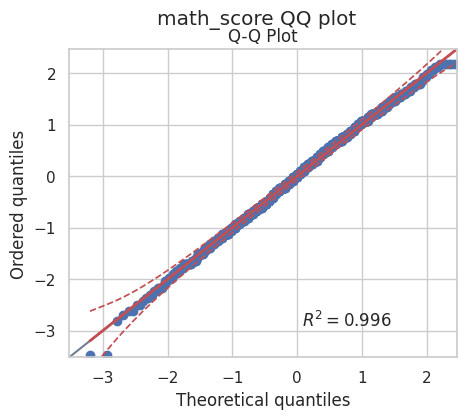

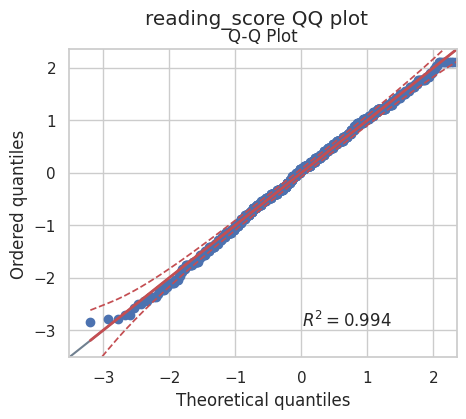

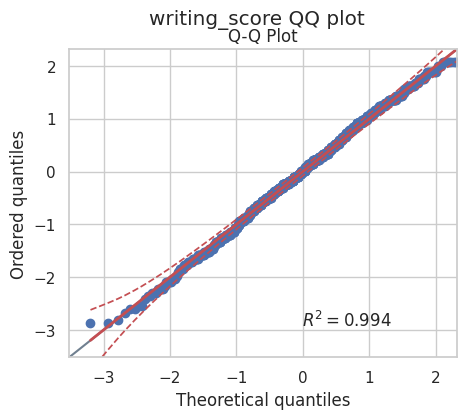

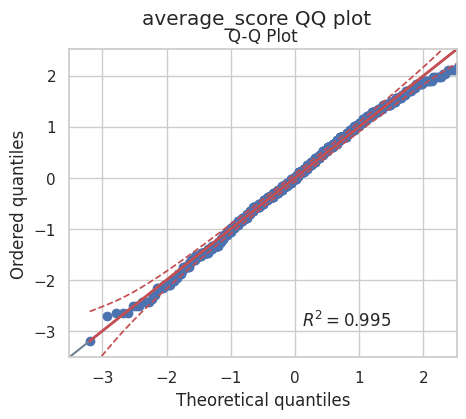

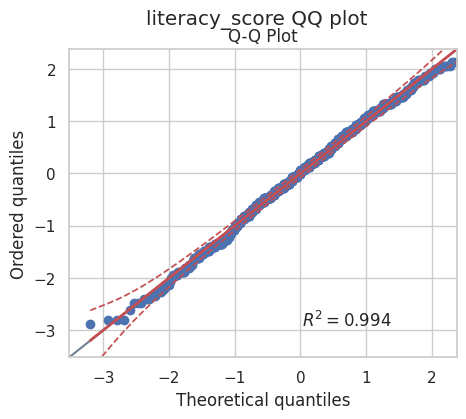

In [33]:
for column in df.columns[5:10]:
    pg.qqplot(df[column], dist='norm')
    plt.suptitle(f'{column} QQ plot')
    plt.show()

This is interesting - we appear to have numerical data that is not, according to the Shapiro-Wilk test, normally distributed. And yet, we have exceptionally good R2 values. We should see what the QQ plots of the transformations are

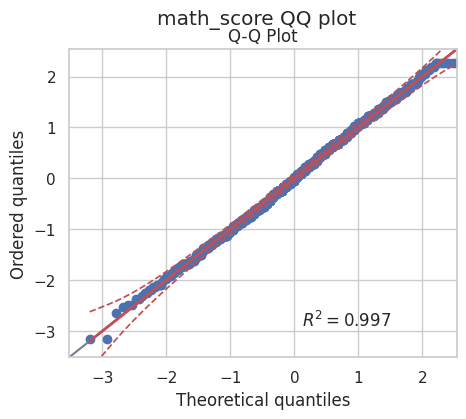

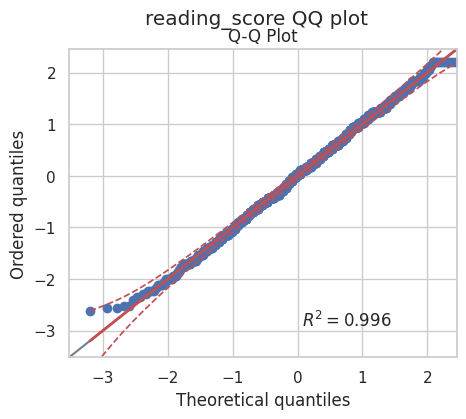

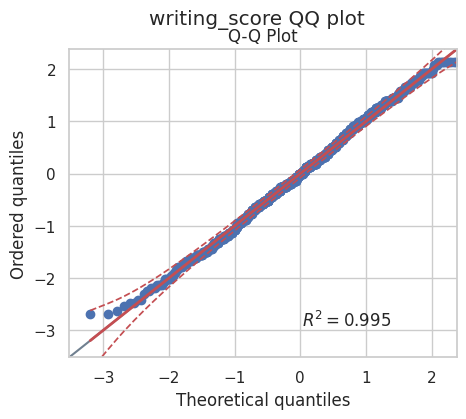

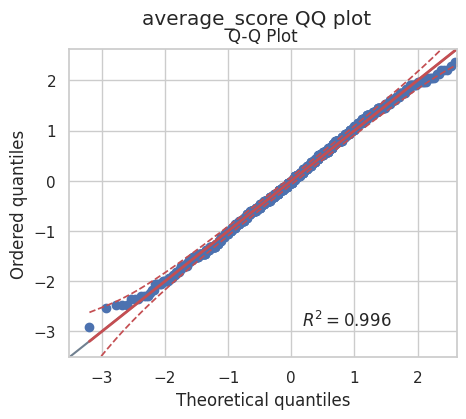

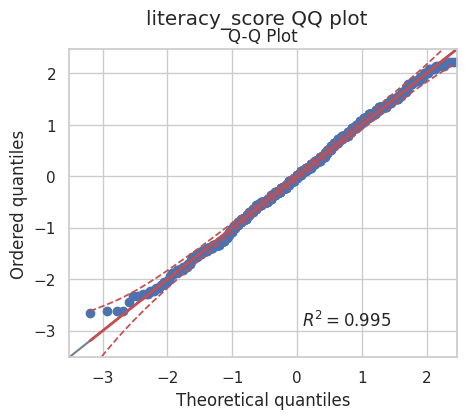

In [35]:
for column in df_box_cox.columns[5:10]:
    pg.qqplot(df_box_cox[column], dist='norm')
    plt.suptitle(f'{column} QQ plot')
    plt.show()

The Box-Cox transformation has improved the R2 scores slightly

Lets see what the Yeo-Johnson transformation has accomplished

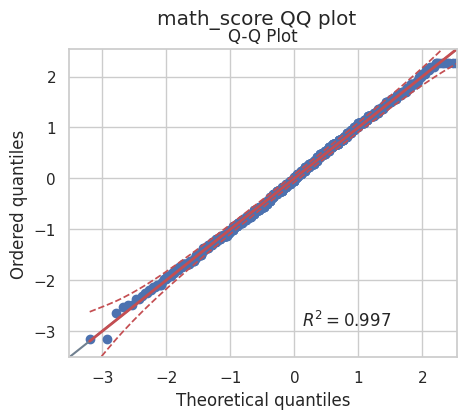

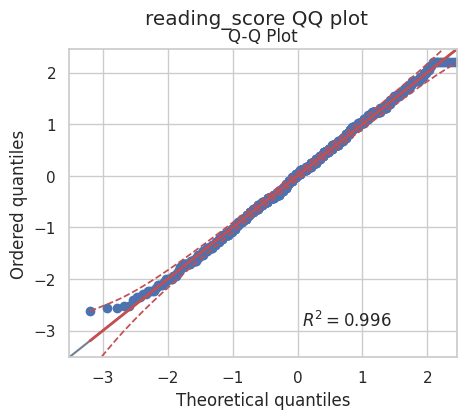

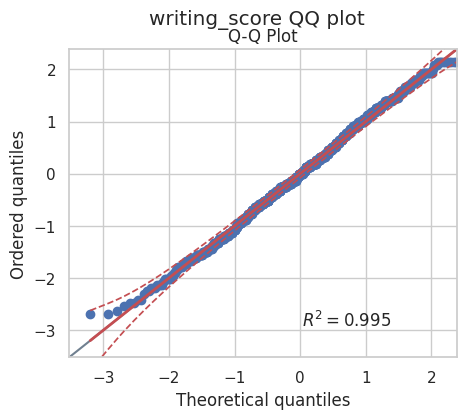

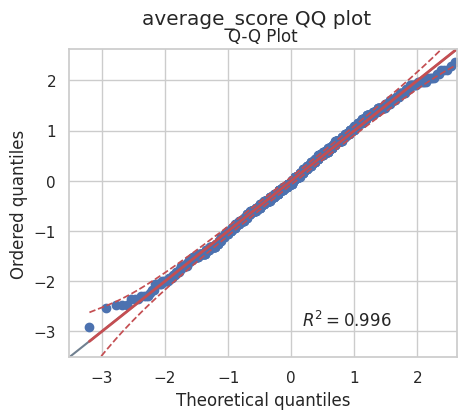

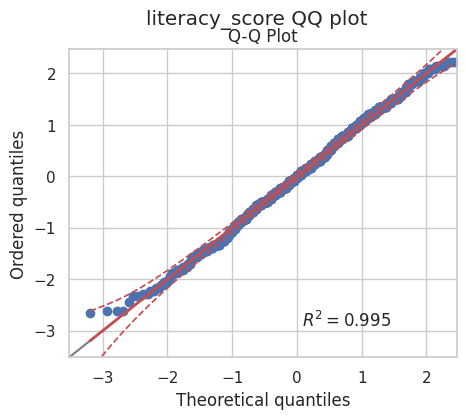

In [36]:
for column in df_yeo_johnson.columns[5:10]:
    pg.qqplot(df_yeo_johnson[column], dist='norm')
    plt.suptitle(f'{column} QQ plot')
    plt.show()

It appears the Yeo-Johnson transformation has achieved similar results to the Box-Cox transformation